### Imports

In [104]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [105]:
buy_threshold = 0.1
sell_threshold = 0.1
starting_balance = 1000000
price_cap_lower = 2
investment_ratio = 0.0005
long_short_ratio = 0.05

run_optimizing = False
google_colab = False

### Data loading

In [106]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    df = pd.read_csv('Full trading data - All models.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models.csv')

In [107]:
# Drop Expire_date column
df.drop('Expire_date', axis=1, inplace=True)

In [108]:
# Filter so its just data for 2015
#df = df[(df["Quote_date"] >= "2015-01-01") & (df["Quote_date"] <= "2018-12-31")]
#df = df[(df["Expiry_date"] >= "2015-01-01") & (df["Expiry_date"] <= "2018-12-31")]

# Choos 5% of the data randomly
df = df.sample(frac=0.02, random_state=1)

In [110]:
display(df.head())

,Quote_date,Price,Bid,Ask,Underlying_last,Strike,TTM,Delta,IV,R,Price_drop,Rolling,GARCH,BS-IV,Heston,LSTM-MLP,Expiry_date,Option_ID
6843912,2021-10-19,0.725,0.65,0.80,4520.22,4875.0,37.0,0.01393,0.10517,0.000593,0.725,4.807812,2.664023,1.401748,-0.533230,0.000000,2021-11-26,2021-11-26-4875.0
7350029,2022-02-03,0.075,0.00,0.15,4476.32,4950.0,10.0,0.00156,0.19072,0.000300,0.075,0.023638,0.036562,0.380906,-1.344529,0.000000,2022-02-14,2022-02-14-4950.0
8166756,2022-09-13,576.900,568.80,585.00,3932.69,3420.0,93.0,0.87023,0.27369,0.032971,576.900,562.192989,546.389716,571.073556,580.260085,604.493200,2022-12-16,2022-12-16-3420.0
1000305,2016-04-06,12.850,12.30,13.40,2066.79,2110.0,43.0,0.27633,0.10735,0.001889,12.850,16.125611,28.226564,18.145237,16.408154,14.752701,2016-05-19,2016-05-19-2110.0
1104658,2016-05-26,639.750,638.20,641.30,2090.09,1440.0,113.0,1.00000,0.00000,0.003430,639.750,651.618523,651.618525,660.113503,645.687565,640.085400,2016-09-16,2016-09-16-1440.0


In [111]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

### Data processing

In [112]:
print(len(df))

175188


# Trading functions

In [113]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Ask']) / df['Ask'] >= buy_threshold
    sell_signal = (df['Bid'] - df['Prediction']) / df['Bid'] >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio = 0.002, long_short_ratio= 0.02, fee = 0.001, stop_loss = 0.2):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    number_of_long_positions = 0
    number_of_short_positions = 0
    entry_prices = {}

    def operation(row):
        nonlocal number_of_long_positions
        nonlocal number_of_short_positions
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        # If price below cap, do nothing
        if row["Price"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        # Calculate net ratio
        if number_of_long_positions + number_of_short_positions == 0:
            net_ratio = 0
        else:
            net_ratio = (number_of_long_positions - number_of_short_positions) / (number_of_long_positions + number_of_short_positions)

        # Buy 
        if row['Signal'] == 1 and position <= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio < long_short_ratio:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + fee)
                position += amount_to_invest / row['Ask']
                number_of_long_positions += 1
                entry_prices[row['Option_ID']] = row['Ask']

        # Sell
        elif row['Signal'] == -1 and position >= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio > -long_short_ratio:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - fee)
            position -= amount_to_sell / row['Bid']
            number_of_short_positions += 1
            entry_prices[row['Option_ID']] = row['Bid']

        # Check if the stop-loss should be triggered
        if row['Option_ID'] in entry_prices:
            entry_price = entry_prices[row['Option_ID']]
            current_price = row['Ask'] if position > 0 else row['Bid']
            # Long
            if position > 0 and (entry_price - current_price) / entry_price >= stop_loss:
                balance += position * current_price * (1 - fee)
                position = 0
                number_of_long_positions -= 1
                del entry_prices[row['Option_ID']]
            # Short
            elif position < 0 and (current_price - entry_price) / entry_price >= stop_loss:
                balance -= position * current_price * (1 + fee)
                position = 0
                number_of_short_positions -= 1
                del entry_prices[row['Option_ID']]

        # Expire
        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0
            if position < 0:
                number_of_short_positions -= 1
            elif position > 0:
                number_of_long_positions -= 1
        
        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance

        # Print progress
        if row.name % 100000 == 0:
            print(row["Quote_date"])
            print("Number of long positions: ", number_of_long_positions)
            print("Number of short positions: ", number_of_short_positions)
            print("Balnace: ", balance)
        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Analysis functions

In [114]:
def sharpe_ratio(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change() - 0.02 / 252
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())
    return sharpe_ratio

In [115]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    
    # Find the risk-free rate for each month from a row with the same YYYY-MM and TTM close to one month
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= 28) & (df_sharpe["TTM"] <= 32)]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby("YYYY-MM").last()["R"]
    
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Returns"] = df_sharpe["Total_value"].pct_change()
    
    df_sharpe["Excess_Returns"] = df_sharpe["Returns"] - df_rf / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    
    return sharpe_ratio

In [116]:
def capm_alpha(df_capm):
    # Find alpha in the CAPM model using linear regression and grouping df by Quote_date, then taking the alpha of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.intercept_[0] * 252

In [117]:
def capm_beta(df_capm):
    # Find beta in the CAPM model using linear regression and grouping df by Quote_date, then taking the beta of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0][0] * 252

In [118]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [119]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [120]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Cash')
    plt.plot(df['Options_value'], label='Net value of options')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Run the code

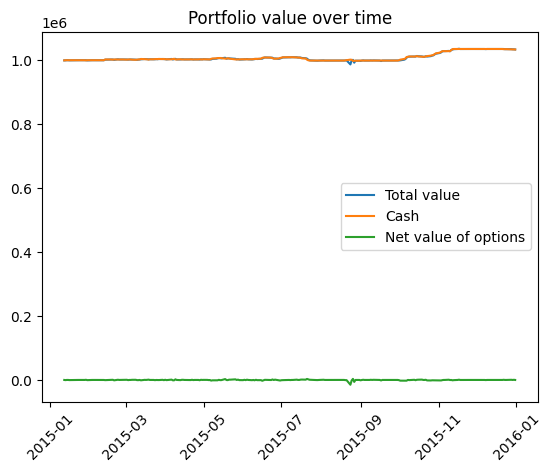

Df year        Quote_date Expiry_date    Price     Bid     Ask  Underlying_last   
1205   2015-01-12  2015-03-06   43.750   43.10   44.40          2028.56  \
2263   2015-01-12  2015-09-30  715.055  709.61  720.50          2028.56   
1906   2015-01-12  2015-03-31  871.105  865.51  876.70          2028.56   
1754   2015-01-12  2015-03-27  207.250  204.30  210.20          2028.56   
1343   2015-01-12  2015-03-13  622.710  616.91  628.51          2028.56   
...           ...         ...      ...     ...     ...              ...   
804986 2015-12-31  2015-12-31    3.650   20.30   28.89          2043.65   
805007 2015-12-31  2015-12-31    0.000    0.00    0.06          2043.65   
804922 2015-12-31  2015-12-31  323.650  339.00  348.10          2043.65   
804855 2015-12-31  2015-12-31  658.650  674.21  683.29          2043.65   
804913 2015-12-31  2015-12-31  368.650  384.00  393.10          2043.65   

        Strike    TTM    Delta       IV         R  Price_drop   
1205    2035.0   52.0  0.4

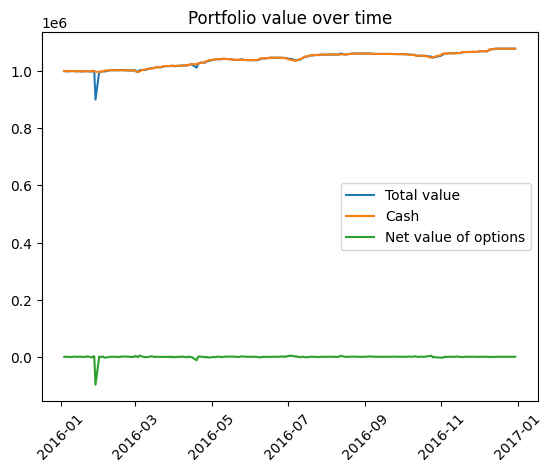

Df year         Quote_date Expiry_date    Price     Bid     Ask  Underlying_last   
809850  2016-01-04  2016-03-17    4.455    4.00    4.91          2012.98  \
809112  2016-01-04  2016-02-26  168.845  167.90  169.79          2012.98   
808871  2016-01-04  2016-02-12   55.355   54.71   56.00          2012.98   
808222  2016-01-04  2016-01-22   63.700   62.90   64.50          2012.98   
810147  2016-01-04  2016-03-31   75.655   75.00   76.31          2012.98   
...            ...         ...      ...     ...     ...              ...   
1549849 2016-12-29  2016-12-30  119.250  114.90  123.60          2249.28   
1549882 2016-12-29  2016-12-30    0.025    0.00    0.05          2249.28   
1553513 2016-12-30  2016-12-30    0.000    0.34    0.41          2239.79   
1553396 2016-12-30  2016-12-30  564.790  568.11  580.50          2239.79   
1553436 2016-12-30  2016-12-30  349.790  353.19  365.51          2239.79   

         Strike   TTM    Delta       IV         R  Price_drop   
809850   2165.

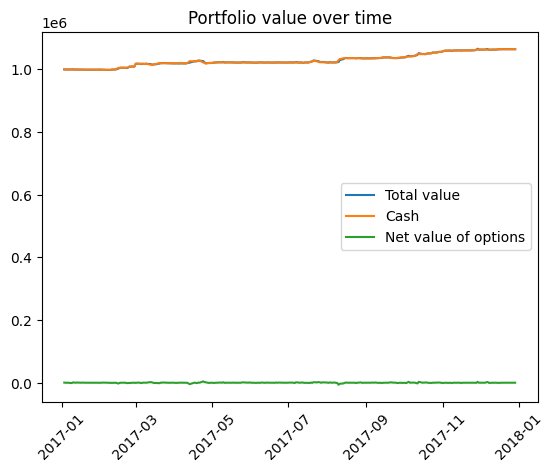

Df year         Quote_date Expiry_date     Price      Bid      Ask  Underlying_last   
1557803 2017-01-03  2017-01-13   495.650   489.70   501.60          2257.44  \
1559193 2017-01-03  2017-02-10   290.845   284.90   296.79          2257.44   
1557473 2017-01-03  2017-01-06   145.295   140.39   150.20          2257.44   
1557784 2017-01-03  2017-01-13   235.995   230.00   241.99          2257.44   
1557797 2017-01-03  2017-01-13   381.100   375.30   386.90          2257.44   
...            ...         ...       ...      ...      ...              ...   
2410371 2017-12-27  2017-12-27   197.220   194.49   199.40          2682.22   
2414157 2017-12-28  2017-12-29   481.595   472.19   491.00          2687.17   
2414153 2017-12-28  2017-12-29  1186.495  1176.89  1196.10          2687.17   
2414073 2017-12-28  2017-12-29   222.545   219.29   225.80          2687.17   
2417748 2017-12-29  2017-12-29   205.220   214.30   220.79          2675.22   

         Strike   TTM    Delta       IV    

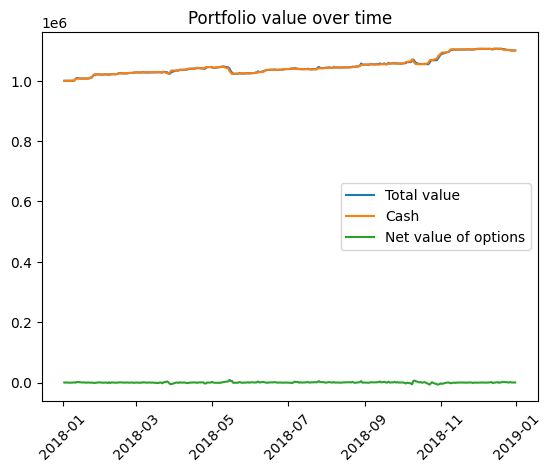

Df year         Quote_date Expiry_date    Price     Bid     Ask  Underlying_last   
2424317 2018-01-02  2018-03-16  300.095  297.19  303.00          2695.87  \
2424902 2018-01-02  2018-12-31  944.705  934.10  955.31          2695.87   
2424507 2018-01-02  2018-04-20  818.105  814.91  821.30          2695.87   
2424500 2018-01-02  2018-03-29  252.140  251.29  252.99          2695.87   
2423473 2018-01-02  2018-02-05   95.455   93.10   97.81          2695.87   
...            ...         ...      ...     ...     ...              ...   
3520755 2018-12-31  2018-12-31    0.000    0.00    0.05          2506.71   
3520638 2018-12-31  2018-12-31  351.710  323.40  332.40          2506.71   
3520680 2018-12-31  2018-12-31  141.710  118.80  121.80          2506.71   
3520587 2018-12-31  2018-12-31  956.710  928.71  937.60          2506.71   
3520688 2018-12-31  2018-12-31  101.710   78.21   80.90          2506.71   

         Strike    TTM    Delta       IV         R  Price_drop   
2424317  2400

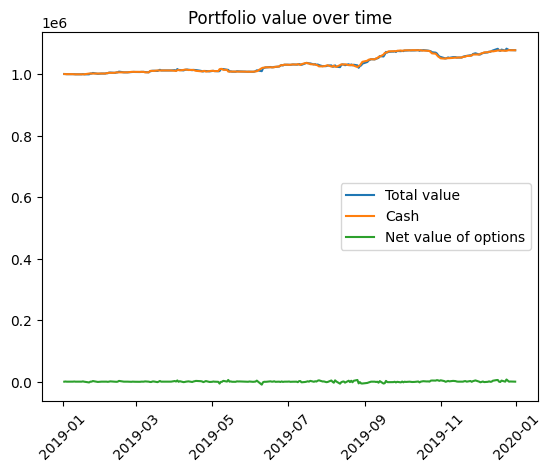

Df year         Quote_date Expiry_date    Price     Bid     Ask  Underlying_last   
3528644 2019-01-02  2019-03-15  136.495  135.30  137.69          2509.98  \
3526544 2019-01-02  2019-01-22   97.595   95.99   99.20          2509.98   
3528441 2019-01-02  2019-02-28  542.845  539.00  546.69          2509.98   
3526360 2019-01-02  2019-01-18   22.205   20.81   23.60          2509.98   
3528723 2019-01-02  2019-03-15    1.700    1.60    1.80          2509.98   
...            ...         ...      ...     ...     ...              ...   
4492543 2019-12-30  2019-12-30  336.810  353.50  356.90          3221.81   
4497141 2019-12-31  2019-12-31    0.000    0.00    0.05          3229.70   
4497110 2019-12-31  2019-12-31    0.000    0.31    0.44          3229.70   
4497024 2019-12-31  2019-12-31  499.700  486.50  490.70          3229.70   
4497135 2019-12-31  2019-12-31    0.000    0.00    0.04          3229.70   

         Strike   TTM    Delta       IV         R  Price_drop   
3528644  2435.

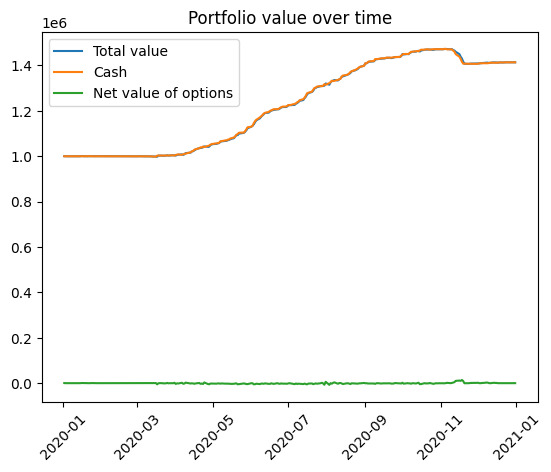

Df year         Quote_date Expiry_date     Price      Bid      Ask  Underlying_last   
4505267 2020-01-02  2020-04-17   684.805   679.41   690.20          3258.14  \
4503948 2020-01-02  2020-02-05   360.250   357.90   362.60          3258.14   
4505753 2020-01-02  2020-11-20  1266.945  1258.69  1275.20          3258.14   
4502495 2020-01-02  2020-01-15     1.125     1.05     1.20          3258.14   
4503710 2020-01-02  2020-02-03   338.750   335.50   342.00          3258.14   
...            ...         ...       ...      ...      ...              ...   
5616724 2020-12-31  2020-12-31   421.310   398.30   401.40          3756.31   
5616674 2020-12-31  2020-12-31   736.310   714.71   717.20          3756.31   
5616650 2020-12-31  2020-12-31   886.310   864.41   867.20          3756.31   
5616798 2020-12-31  2020-12-31     0.000     0.29     0.45          3756.31   
5616701 2020-12-31  2020-12-31   566.310   543.30   546.40          3756.31   

         Strike    TTM    Delta       IV   

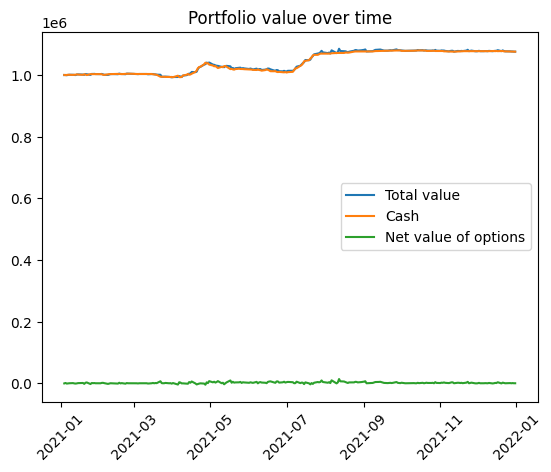

Df year         Quote_date Expiry_date     Price      Bid      Ask  Underlying_last   
5622236 2021-01-04  2021-01-04   276.380   330.40   335.29          3701.38  \
5626773 2021-01-04  2021-05-21    15.455    15.10    15.81          3701.38   
5626821 2021-01-04  2021-05-28  1296.950  1285.50  1308.40          3701.38   
5627355 2021-01-04  2021-09-17   792.710   787.21   798.21          3701.38   
5626898 2021-01-04  2021-05-28   300.445   299.39   301.50          3701.38   
...            ...         ...       ...      ...      ...              ...   
7200250 2021-12-31  2021-12-31  1366.390  1379.60  1384.60          4766.39   
7200395 2021-12-31  2021-12-31   561.390   573.90   579.50          4766.39   
7200287 2021-12-31  2021-12-31  1101.390  1114.40  1120.10          4766.39   
7200294 2021-12-31  2021-12-31  1066.390  1079.40  1085.10          4766.39   
7200462 2021-12-31  2021-12-31   226.390   240.90   243.10          4766.39   

         Strike    TTM    Delta       IV   

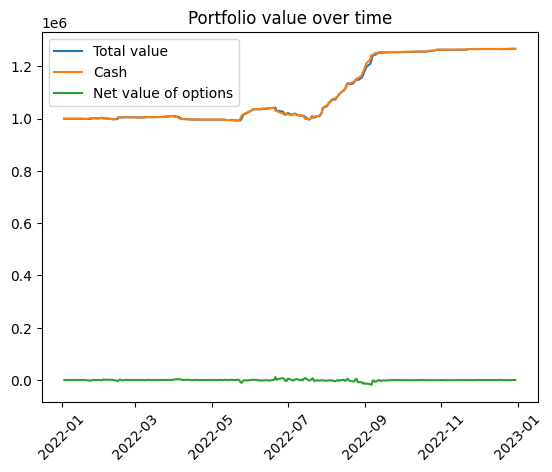

Df year         Quote_date Expiry_date    Price      Bid      Ask  Underlying_last   
7212553 2022-01-03  2022-03-31  1188.15  1184.10  1192.20          4795.57  \
7212038 2022-01-03  2022-03-18   569.45   566.00   572.90          4795.57   
7207828 2022-01-03  2022-01-05  1020.45  1017.60  1023.30          4795.57   
7208523 2022-01-03  2022-01-12   153.95   151.00   156.90          4795.57   
7211131 2022-01-03  2022-02-18   866.55   863.10   870.00          4795.57   
...            ...         ...      ...      ...      ...              ...   
8567476 2022-12-30  2022-12-30     0.00     1.45     1.55          3839.81   
8567272 2022-12-30  2022-12-30  1189.81  1195.70  1199.70          3839.81   
8567276 2022-12-30  2022-12-30  1099.81  1105.90  1109.50          3839.81   
8567526 2022-12-30  2022-12-30     0.00     0.00     0.05          3839.81   
8567564 2022-12-30  2022-12-30     0.00     0.00     0.05          3839.81   

         Strike   TTM    Delta       IV         R  Pric

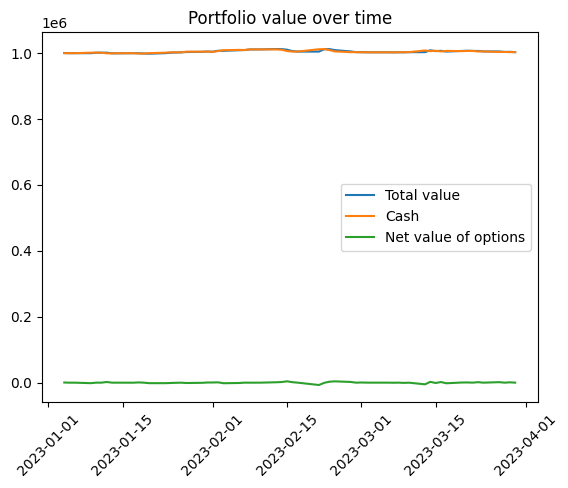

Df year         Quote_date Expiry_date    Price    Bid     Ask  Underlying_last   
8573059 2023-01-04  2023-01-20  629.450  626.0  632.90          3853.39  \
8571922 2023-01-04  2023-01-06  899.950  898.2  901.70          3853.39   
8571732 2023-01-04  2023-01-05    4.850    4.8    4.90          3853.39   
8573255 2023-01-04  2023-01-23  106.100  104.8  107.40          3853.39   
8572367 2023-01-04  2023-01-11   94.950   93.5   96.40          3853.39   
...            ...         ...      ...    ...     ...              ...   
8758517 2023-03-29  2023-03-30    2.425    2.4    2.45          4028.28   
8758488 2023-03-29  2023-03-30   41.200   40.8   41.60          4028.28   
8759009 2023-03-30  2023-03-30  115.950   92.8   93.90          4050.95   
8758979 2023-03-30  2023-03-30  265.950  241.6  244.50          4050.95   
8759022 2023-03-30  2023-03-30   50.950   32.5   33.30          4050.95   

         Strike   TTM    Delta       IV       R  Price_drop   
8573059  3225.0  15.0  0.998

In [121]:
# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=["Year", "Starting balance", "Ending balance", "Profit", "Profit per trade", "Profit per trading day", 
                                "Sharpe ratio", "CAPM alpha", "Annualized return in percent", "Max drawdown"])

# Get the list of years present in the data
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
years = df['Quote_date'].dt.year.unique()

# Sort the years
years.sort()

# Iterate over each year
for year in years:
    df_year = df[df['Quote_date'].dt.year == year].copy()
    
    if not df_year.empty:
        # Execute operations
        buy_signal, sell_signal = generate_buy_sell_signals(df_year, buy_threshold, sell_threshold)
        df_year = trader(df_year, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio)
        df_year = calculate_options_value(df_year)

        # Calculate metrics
        ending_balance = df_year['Balance'].iloc[-1]
        profit = ending_balance - starting_balance
        num_trades = df_year[df_year["Price"] > 1]["Signal"].abs().sum()
        profit_per_trade = profit / num_trades

        trading_days = df_year['Quote_date'].unique().shape[0] - 1
        profit_per_day = profit / trading_days
        num_days = (df_year['Quote_date'].max() - df_year['Quote_date'].min()).days

        annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

        plot(df_year)
        # Create a DataFrame for this year's metrics
        year_metrics = pd.DataFrame({
            "Year": [year], 
            "Starting balance": [starting_balance], 
            "Ending balance": [ending_balance.round(0)], 
            "Profit": [profit.round(0)], 
            "Profit per trade": [profit_per_trade.round(2)], 
            "Profit per trading day": [profit_per_day.round(2)],
            "Sharpe ratio": [sharpe_ratio_monthly(df_year).round(2)], 
            "CAPM alpha": [capm_alpha(df_year).round(2)], 
            "Annualized return in percent": [annualized_return.round(2)], 
            "Max drawdown": [max_drawdown(df_year).round(2)]
        })
        # Add metrics to the results DataFrame
        results = pd.concat([results, year_metrics])

# Reset index of the results DataFrame
results.reset_index(drop=True, inplace=True)

# Print the results DataFrame
print(results)

In [122]:
display(results)

# Add a final row to the results DataFrame with the average metrics
results.loc["Average"] = results.mean()

# Turn year, starting balance and ending balance, profit into integers
results[["Year", "Starting balance", "Ending balance", "Profit"]] = results[["Year", "Starting balance", "Ending balance", "Profit"]].astype(int)
#Remove profit per trad and profit per trading day
results = results.drop(columns=["Profit per trade", "Profit per trading day"])
# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "alpha", "Return", "MDD"]
# Round to 2 decimals
float_cols = ["Sharpe", "alpha", "Return", "MDD"]
# Turn the columns into floats
results[float_cols] = results[float_cols].astype(float)

# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "alpha", "Return", "MDD"]

results[float_cols] = results[float_cols].round(2)
print(results.to_latex(index=False, float_format="%.2f"))

,Year,Starting balance,Ending balance,Profit,Profit per trade,Profit per trading day,Sharpe ratio,CAPM alpha,Annualized return in percent,Max drawdown
0,2015,1000000,1034109.0,34109.0,19.51,139.22,1.34,0.03,3.53,-2.23
1,2016,1000000,1078834.0,78834.0,59.14,315.34,1.78,0.10,7.97,-10.02
2,2017,1000000,1064197.0,64197.0,32.24,257.82,3.00,0.06,6.51,-0.81
3,2018,1000000,1100574.0,100574.0,28.71,400.69,1.47,0.10,10.12,-2.37
4,2019,1000000,1077211.0,77211.0,33.38,313.87,1.20,0.07,7.77,-2.53
5,2020,1000000,1413348.0,413348.0,104.33,1660.03,2.81,0.35,41.47,-4.48
6,2021,1000000,1075928.0,75928.0,18.83,309.91,0.92,0.07,7.68,-2.79
7,2022,1000000,1267004.0,267004.0,36.75,1047.08,1.71,0.24,27.03,-4.40
8,2023,1000000,1002640.0,2640.0,4.20,44.75,-12.87,0.00,1.14,-1.01


\begin{tabular}{rrrrrrrr}
\toprule
Year & Starting & Ending & Profit & Sharpe & alpha & Return & MDD \\
\midrule
2015 & 1000000 & 1034109 & 34109 & 1.34 & 0.03 & 3.53 & -2.23 \\
2016 & 1000000 & 1078834 & 78834 & 1.78 & 0.10 & 7.97 & -10.02 \\
2017 & 1000000 & 1064197 & 64197 & 3.00 & 0.06 & 6.51 & -0.81 \\
2018 & 1000000 & 1100574 & 100574 & 1.47 & 0.10 & 10.12 & -2.37 \\
2019 & 1000000 & 1077211 & 77211 & 1.20 & 0.07 & 7.77 & -2.53 \\
2020 & 1000000 & 1413348 & 413348 & 2.81 & 0.35 & 41.47 & -4.48 \\
2021 & 1000000 & 1075928 & 75928 & 0.92 & 0.07 & 7.68 & -2.79 \\
2022 & 1000000 & 1267004 & 267004 & 1.71 & 0.24 & 27.03 & -4.40 \\
2023 & 1000000 & 1002640 & 2640 & -12.87 & 0.00 & 1.14 & -1.01 \\
2019 & 1000000 & 1123760 & 123760 & 0.15 & 0.11 & 12.58 & -3.40 \\
\bottomrule
\end{tabular}



In [123]:
# Turn year, starting balance and ending balance, profit into integers
results[["Year", "Starting balance", "Ending balance", "Profit"]] = results[["Year", "Starting balance", "Ending balance", "Profit"]].astype(int)
#Remove profit per trad and profit per trading day
results = results.drop(columns=["Profit per trade", "Profit per trading day"])
# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "alpha", "Return", "MDD"]
# Round to 2 decimals
float_cols = ["Sharpe", "alpha", "Return", "MDD"]
# Turn the columns into floats
results[float_cols] = results[float_cols].astype(float)

# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "alpha", "Return", "MDD"]

results[float_cols] = results[float_cols].round(2)
print(results.to_latex(index=False, float_format="%.2f"))

KeyError: "['Starting balance', 'Ending balance'] not in index"

### Post analysis

In [ ]:
if run_optimizing == False:
    plot(df)

## Threshold search

In [ ]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '2015-2018 - v12',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'sell_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'price_cap_lower': {
            'values': [1, 2]},
        'investment_ratio': {
            'values': [5e-4, 5e-5, 5e-6]},
        'long_short_ratio': {
            'values': [0.05, 0.3]}
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [ ]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, starting_balance=100000, price_cap_lower = run.config.price_cap_lower, investment_ratio = run.config.investment_ratio, long_short_ratio = run.config.long_short_ratio)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio_monthly(df), "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum(), "alpha": capm_alpha(df), "long_short_ratio": run.config.long_short_ratio, "price_cap_lower": run.config.price_cap_lower, "investment_ratio": run.config.investment_ratio})
        # Wandb callback
        print_results(df, 100000)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)